In [105]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import itertools

Much of this code is adapted from a Medium Article by Chris Fotache that details how to use pretrained models in PyTorch.

https://towardsdatascience.com/how-to-train-an-image-classifier-in-pytorch-and-use-it-to-perform-basic-inference-on-single-images-99465a1e9bf5

The goal of this Notebook is to produce a model that can predict an image's flood depth level.  To do this we will download a pretrained image classification CNN via PyTorch and tune it to our training data.

The goal of this Notebook is not to attempt extensive hyperparameter optimatizion, model evaluation, model inference, and model evaluation.  All of these are important parts of the data science process.  However, for the purposes of this project, a two-week deep learning crash course, we will focus on the deliverable: build a model that can predict flood depth.

In [114]:
# Set our random seed.
torch.manual_seed(20)

In [107]:
#HYPERPARAMETERS - manually tuned to produce a decent accuracy

data_dir = '/Users/nlonberg/Desktop/train' #FILEPATH

img_resize_dims = [224,224] # ResNet50 requires 224 by 224 size images
# Batch sizes are typically base2
train_batch_size = 8
test_batch_size = 8 # Number of samples between parameter adjustments
test_size = 0.2
epochs = 4 # Epochs = Number of times to fully loop back over training data to tune hyperparameters
train_size = 631 # 80% of the final 786
test_size = 157

In [115]:
# Recruit GPU if available for performance enhancement
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")

We have chosen ResNet50 as our pretained model.  ResNet50 is a convolutional neural network trained on a huge database of images.  CNNs perform well on image classification and our particular model has 50 layers.

In [109]:
#MODEL SELECTION: PRETRAINED RESNET50
model_name = "ResNet50"
model = models.resnet50(pretrained=True)
#model = models.vgg16(pretrained=True)

Let's split our data into training and testing.

In [116]:
# train_test splits the data into training and testing sets
def train_test(datadir, valid_size = .2):
    
    # Build pytorch image transformation pipelines
    # Bootstrapping transformers could go HERE
    train_transforms = transforms.Compose([transforms.Resize(img_resize_dims),
                                       transforms.ToTensor(),
                                       ])
    test_transforms = transforms.Compose([transforms.Resize(img_resize_dims),
                                      transforms.ToTensor(),
                                      ])
    
    # Load in images
    data = datasets.ImageFolder(data_dir,       
                    transform=train_transforms)
    
    train_data, test_data = torch.utils.data.random_split(data, [train_size, test_size])
        
    trainloader = torch.utils.data.DataLoader(train_data, batch_size=train_batch_size)
    testloader = torch.utils.data.DataLoader(test_data, batch_size=test_batch_size)
    return trainloader, testloader, train_data, test_data

trainloader, testloader, train_data, test_data = train_test(data_dir, test_size)
#print(trainloader.dataset.classes)

We will freeze the first 49 layers to further training and redefine the last layer.

In [111]:
# Freeze pretrained model's layers
for param in model.parameters():
    param.requires_grad = False

# Redefine final layer(s) for training
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(), # "ReLu Is Great" -Kelly, Used for internal layer for many NNs
                                 # Rectified linear unit function
                                 nn.Dropout(0.2),
                                 # Dropout Layer: Randomly zero some neurons with p=20% to prevent overfitting
                                 nn.Linear(512, 10), # Activation Function Used for Output for Regression
                                 # Linear Transformation Layer
                                 nn.LogSoftmax(dim=1)) # Good for Multi-class classifications
                                 # Log Softmax function for penalizing incorrect classifications
# Define Loss Function
criterion = nn.NLLLoss()
# Root-Mean-Squared Propagation is also a optimizer that is used
# Define Gradient Descent Optimizer
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device);

Let's build the model by training our last layer.

In [112]:
steps = 0
running_loss = 0
# Print every 5 batches
print_every = 5
train_losses, test_losses = [], []
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()
            
torch.save(model, model_name+'.pth')

Epoch 1/4.. Train loss: 4.265.. Test loss: 3.708.. Test accuracy: 0.214
Epoch 1/4.. Train loss: 4.314.. Test loss: 3.216.. Test accuracy: 0.144
Epoch 1/4.. Train loss: 1.949.. Test loss: 1.929.. Test accuracy: 0.480
Epoch 1/4.. Train loss: 2.041.. Test loss: 1.835.. Test accuracy: 0.220
Epoch 1/4.. Train loss: 1.876.. Test loss: 1.555.. Test accuracy: 0.323
Epoch 1/4.. Train loss: 1.783.. Test loss: 1.617.. Test accuracy: 0.345
Epoch 1/4.. Train loss: 1.635.. Test loss: 1.584.. Test accuracy: 0.258
Epoch 1/4.. Train loss: 1.839.. Test loss: 1.481.. Test accuracy: 0.361
Epoch 1/4.. Train loss: 1.663.. Test loss: 1.377.. Test accuracy: 0.540
Epoch 1/4.. Train loss: 1.517.. Test loss: 1.536.. Test accuracy: 0.324
Epoch 1/4.. Train loss: 1.639.. Test loss: 1.287.. Test accuracy: 0.518
Epoch 1/4.. Train loss: 1.587.. Test loss: 1.382.. Test accuracy: 0.424
Epoch 1/4.. Train loss: 1.449.. Test loss: 1.350.. Test accuracy: 0.410
Epoch 1/4.. Train loss: 1.593.. Test loss: 1.365.. Test accuracy

Our final model has 64.3% accuracy on the testing set.  This is very good because we only trained on ~600 images (relatively low for an image classifier) and our model is a multiclass classifier, meaning that not all false positives and negatives are created equal.

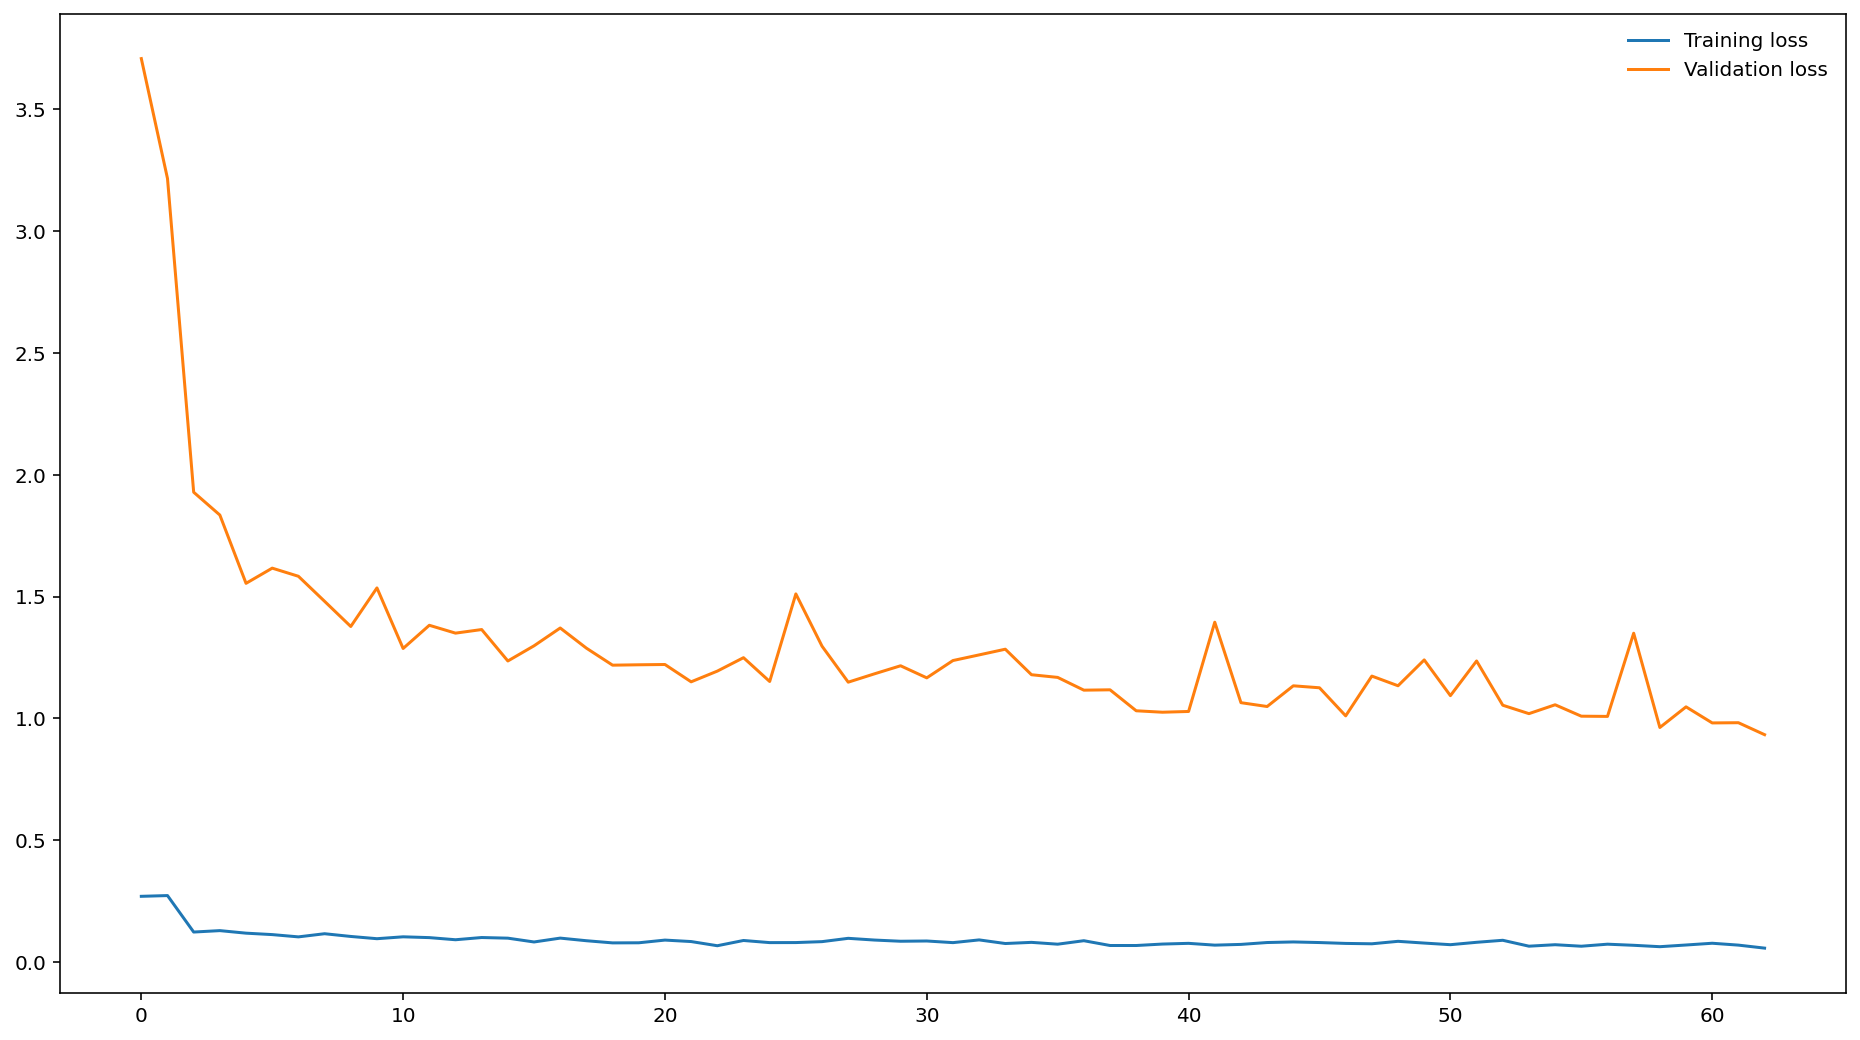

In [113]:
plt.figure(figsize=(16,9))
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

Finally, this graph visualized the gradient descent that is occuring as the CNN tries to minize the loss functions while tuning the final layer.  Our final training and testing losses, settled on after 4 rounds of iteration over the training set, were the lowest the gradient descent reached over its run.